In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_281.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_1.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_256.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_221.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_138.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_93.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_198.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_137.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_120.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_13.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_40.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_217.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_3.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_286.png
/kaggle/input/feature-selelcted-dataset/t

In [2]:
!pip install lime shap -q

In [3]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,  Flatten
from tensorflow.keras.optimizers import Adam
from PIL import Image
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import json
from tensorflow.keras.applications.vgg16 import preprocess_input
from lime import lime_image
import shap
from skimage.segmentation import mark_boundaries
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.io import imread
from skimage.transform import resize
from skimage.segmentation import mark_boundaries


2025-04-17 15:31:48.558244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744903908.765246      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744903908.827223      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
base_path = "/kaggle/input/feature-selelcted-dataset"
categories = ['normal', 'covid19', 'pneumonia']
image_size = (224, 224)

In [5]:
def load_images_from_folder(folder, label_name, images_list, labels_list):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            images_list.append(img)
            labels_list.append(label_name)

In [6]:
train_path = os.path.join(base_path, 'train')
train_images, train_labels = [], []

for category in categories:
    category_path = os.path.join(train_path, category)
    print(f"Loading training data from {category_path}...")
    load_images_from_folder(category_path, category, train_images, train_labels)

Loading training data from /kaggle/input/feature-selelcted-dataset/train/normal...
Loading training data from /kaggle/input/feature-selelcted-dataset/train/covid19...
Loading training data from /kaggle/input/feature-selelcted-dataset/train/pneumonia...


In [7]:
test_path = os.path.join(base_path, 'test')
test_images, test_labels = [], []

for category in categories:
    category_path = os.path.join(test_path, category)
    print(f"Loading test data from {category_path}...")
    load_images_from_folder(category_path, category, test_images, test_labels)

Loading test data from /kaggle/input/feature-selelcted-dataset/test/normal...
Loading test data from /kaggle/input/feature-selelcted-dataset/test/covid19...
Loading test data from /kaggle/input/feature-selelcted-dataset/test/pneumonia...


In [8]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
train_labels_cat = np.array(train_labels)
test_labels_cat = np.array(test_labels)

In [9]:
test_labels_cat

array(['normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'norm

In [10]:
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [11]:
train_labels[train_labels == "covid19"] = "Patient"
train_labels[train_labels == "normal"] = "Normal"
train_labels[train_labels == "pneumonia"] = "Patient"

In [12]:
test_labels[test_labels == "covid19"] = "Patient"
test_labels[test_labels == "normal"] = "Normal"
test_labels[test_labels == "pneumonia"] = "Patient"

In [13]:
label_mapping = {'Patient':0, 'Normal':1}

train_labels_int = np.array([label_mapping[label] for label in train_labels], dtype='int32')
test_labels_int = np.array([label_mapping[label] for label in test_labels], dtype='int32')

train_labels = tf.keras.utils.to_categorical(train_labels_int, num_classes=2).astype('float32')
test_labels = tf.keras.utils.to_categorical(test_labels_int, num_classes=2).astype('float32')

In [14]:
label_mapping = {'covid19': 0, 'pneumonia': 1,'normal': 2}

train_labels_int = np.array([label_mapping[label] for label in train_labels_cat], dtype='int32')
test_labels_int = np.array([label_mapping[label] for label in test_labels_cat], dtype='int32')

train_labels_c = tf.keras.utils.to_categorical(train_labels_int, num_classes=3).astype('float32')
test_labels_c = tf.keras.utils.to_categorical(test_labels_int, num_classes=3).astype('float32')

In [15]:
class_dict = {0:'Patient',
              1:'Normal',
         }



In [16]:
class_dict_c = {0:'COVID19',
              1:'NORMAL',
              2:'PNEUMONIA'}

# Step 1 Model to classify Normal or Patient

In [17]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output

x = Flatten()(x)

x = Dense(4096, activation='relu')(x)  
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)  
x = Dropout(0.5)(x)
x = Dense(2, activation='sigmoid')(x)  #changed this not like the paper bec i have only 2 classes and so using sigmoid
# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), #learning rate 0.001 like the paper
              loss='binary_crossentropy', #sparse_categorical_crossentropy like the paper
              metrics=['accuracy'])

# Print model summary
model.summary()

I0000 00:00:1744903939.712499      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744903939.713247      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 119,554,050 (456.06 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
batch_size = 32 #batch_size 32 like the paper
epochs = 25

# Train the model
history = model.fit(
    train_images, train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, test_labels),
    verbose=1
)


Epoch 1/25


I0000 00:00:1744903946.476610      69 service.cc:148] XLA service 0x7e545800ff10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744903946.483216      69 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744903946.483238      69 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744903946.862938      69 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/38 ━━━━━━━━━━━━━━━━━━━━ 9:38 16s/step - accuracy: 0.6562 - loss: 0.6821

I0000 00:00:1744903959.008861      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 635ms/step - accuracy: 0.7663 - loss: 3.9653 - val_accuracy: 0.9735 - val_loss: 0.1412
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accuracy: 0.9826 - loss: 0.1318 - val_accuracy: 0.9735 - val_loss: 0.0940
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - accuracy: 0.9850 - loss: 0.0923 - val_accuracy: 0.9735 - val_loss: 0.1108
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.9830 - loss: 0.0833 - val_accuracy: 0.9702 - val_loss: 0.1361
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.9866 - loss: 0.0545 - val_accuracy: 0.9702 - val_loss: 0.2027
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step - accuracy: 0.9936 - loss: 0.0378 - val_accuracy: 0.9702 - val_loss: 0.1665
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.9918 - loss: 0.0442 - val_accuracy: 0.9735 - val_loss: 0.1513
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step - accuracy: 0.9855 - loss: 0.0682 - val_accuracy: 0.9768 - val

# Step 2 Model to Classify Normal, Covid19, Pneumonia

In [19]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output

x = Flatten()(x)

x = Dense(4096, activation='relu')(x)  
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)  
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)  #changed this not like the paper bec i have only 3 classes

# Create the final model
model_c = Model(inputs=base_model.input, outputs=x)

# Compile the model
model_c.compile(optimizer=Adam(learning_rate=0.001), #learning rate 0.001 like the paper
               loss='categorical_crossentropy', #sparse_categorical_crossentropy like the paper
              metrics=['accuracy'])

# Print model summary
model_c.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,272,835 (512.21 MB)

 Trainable params: 119,558,147 (456.08 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [20]:
batch_size = 32 #batch_size 32 like the paper
epochs = 25

# Train the model
history_c = model_c.fit(
    train_images, train_labels_c,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, test_labels_c),
    verbose=1
)


Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 352ms/step - accuracy: 0.5290 - loss: 11.2155 - val_accuracy: 0.7781 - val_loss: 0.4856
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 260ms/step - accuracy: 0.7590 - loss: 0.5179 - val_accuracy: 0.7219 - val_loss: 0.5346
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 270ms/step - accuracy: 0.7938 - loss: 0.4382 - val_accuracy: 0.8444 - val_loss: 0.3842
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 273ms/step - accuracy: 0.8378 - loss: 0.3734 - val_accuracy: 0.8245 - val_loss: 0.3707
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step - accuracy: 0.8409 - loss: 0.3684 - val_accuracy: 0.8742 - val_loss: 0.3304
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step - accuracy: 0.8500 - loss: 0.3344 - val_accuracy: 0.9007 - val_loss: 0.3056
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - accuracy: 0.9146 - loss: 0.2367 - val_accuracy: 0.8477 - val_loss: 0.3509
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 0.8781 - loss: 0.2891 - val_acc

# Training and Validation Loss

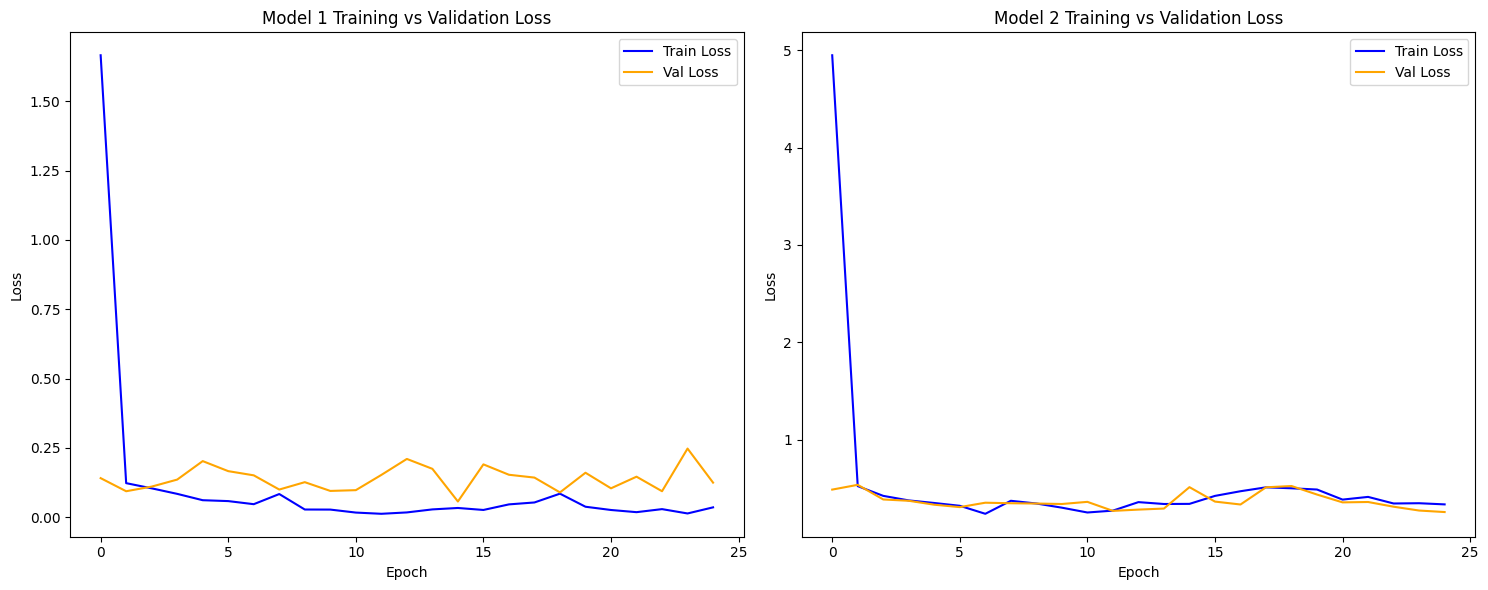

In [21]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model 1 Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_c.history['loss'], label='Train Loss', color='blue')
plt.plot(history_c.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model 2 Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Training and Validation Accuracy

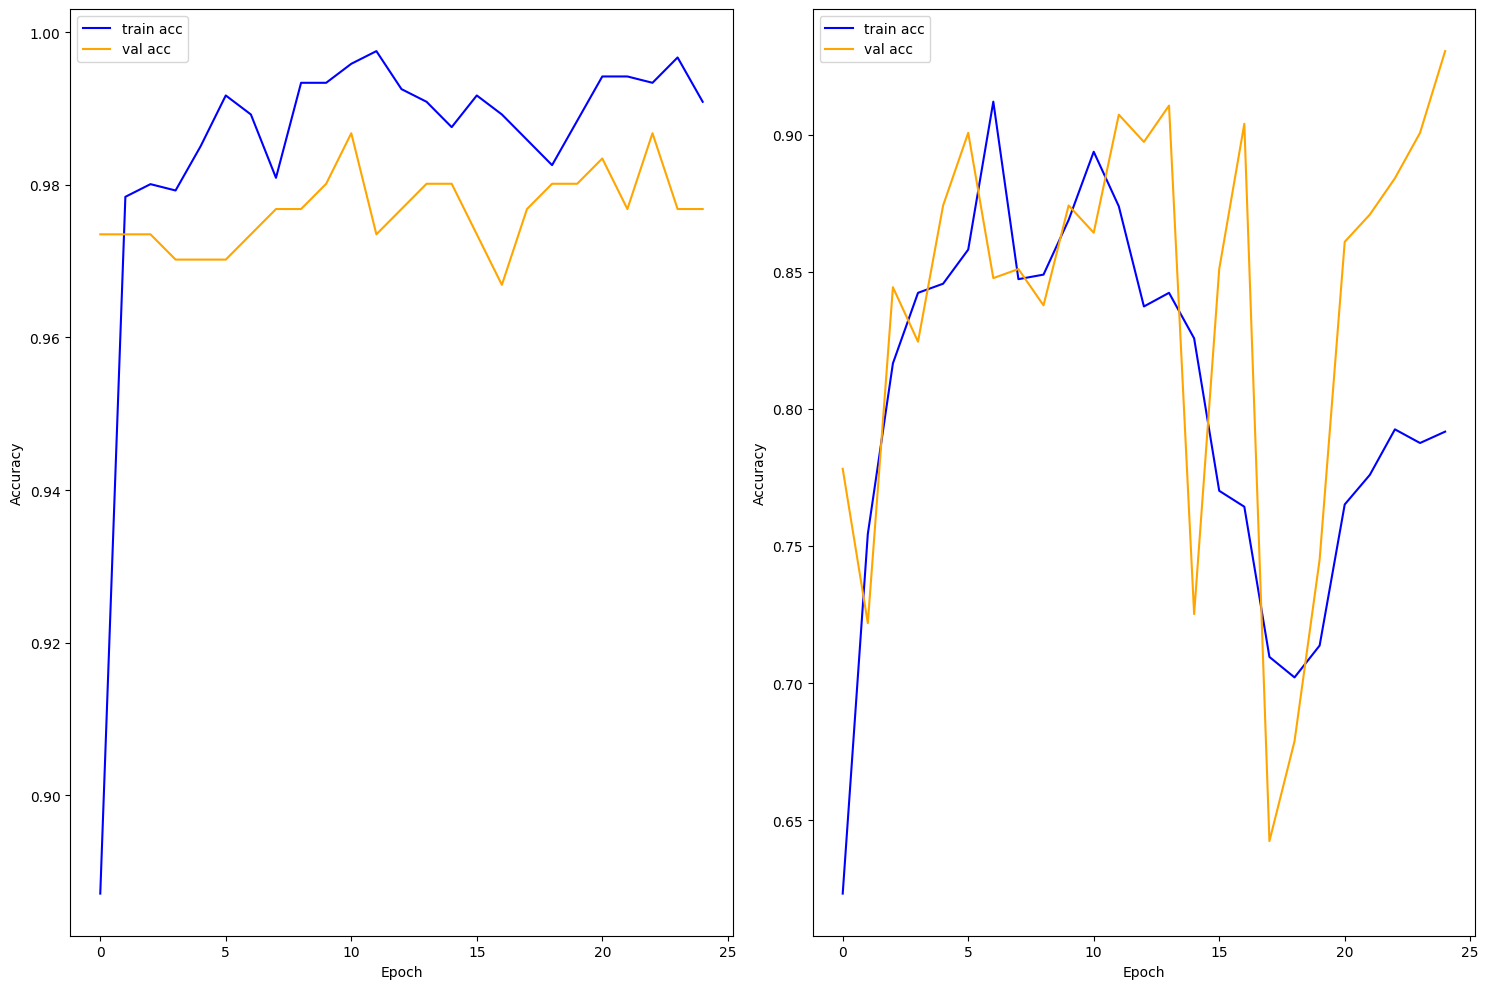

In [22]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

plt.plot(history.history['accuracy'], label='train acc', color='blue')
plt.plot(history.history['val_accuracy'], label='val acc', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_c.history['accuracy'], label='train acc', color='blue')
plt.plot(history_c.history['val_accuracy'], label='val acc', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


#  Confusion Matrix

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step


Text(0.5, 1.0, 'Confusion Matrix')

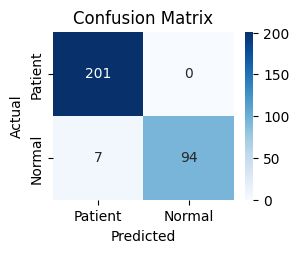

In [23]:
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

class_names = ['Patient', 'Normal']

true_classes = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_classes, y_pred_classes)


plt.subplot(2, 2, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step


Text(0.5, 1.0, 'Confusion Matrix')

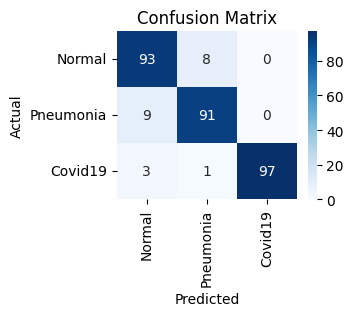

In [24]:
y_pred = model_c.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

class_names = ['Normal', 'Pneumonia', 'Covid19']
true_classes = np.argmax(test_labels_c, axis=1)

cm = confusion_matrix(true_classes, y_pred_classes)

plt.subplot(2, 2, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# GRAD CAM

In [25]:
def gradCam(image, true_label, layer_conv_name, model, which):
    model_grad = tf.keras.models.Model(inputs=model.input, 
                                       outputs=[model.get_layer(layer_conv_name).output, 
                                                model.output])
    pred = []
    loss = None
    with tf.GradientTape() as tape:
        conv_output, predictions = model_grad(image)

        pred.append(np.argmax(predictions))
        
        tape.watch(conv_output)
        if which == "Categorical":
          loss = tf.keras.losses.categorical_crossentropy(true_label, predictions)
        else:
          loss = tf.losses.binary_crossentropy(true_label, predictions)
        
    
    grad = tape.gradient(loss, conv_output)
    grad = tf.reduce_mean(tf.abs(grad), axis=(0, 1, 2))
    
    conv_output = np.squeeze(conv_output.numpy())
    
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= grad[i]
        
    heatmap = tf.reduce_mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / tf.reduce_max(heatmap + 1e-8)  
    heatmap = cv2.resize(heatmap.numpy(), (224, 224))
    pred = np.array(pred)
    return np.squeeze(heatmap), np.squeeze(image), pred

In [26]:
def getHeatMap(images, labels, model, which):
    heatmaps = []
    predictions = []
    for index in range(128):
        heatmap, image, pred = gradCam(images[index:index+1], 
                                 labels[index:index+1], 
                                 'block5_conv3', model, which) 
        heatmaps.append(heatmap)
        predictions.append(pred)
    return np.array(heatmaps), predictions

In [27]:
class_dict_c = {0:'covid19',
              1:'normal',
              2:'pneumonia'}
def draw(images, gradcam_heatmaps, labels, pred,  num_images=6):
    plt.figure(figsize=(12, 4 * num_images))
    for i in range(num_images):
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(images[i])
        title_pred = class_dict_c[pred[i][0]]
        title_actual = class_dict_c[np.argmax(labels[i])]
        plt.title(f'Predicted: {title_pred}\nActual: {title_actual}')

  
        
        plt.axis('off')

        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(images[i])
        plt.imshow(gradcam_heatmaps[i], alpha=0.6, cmap='jet')
        plt.title('Grad-CAM')
        plt.axis('off')

    plt.tight_layout()
    plt.show()



# LIME with model for classifying Normal or Covid19 or Pneumonia

In [28]:
heatmaps, pred = getHeatMap(test_images, test_labels_c, model_c, "Categorical")
print(heatmaps.shape)

(128, 224, 224)


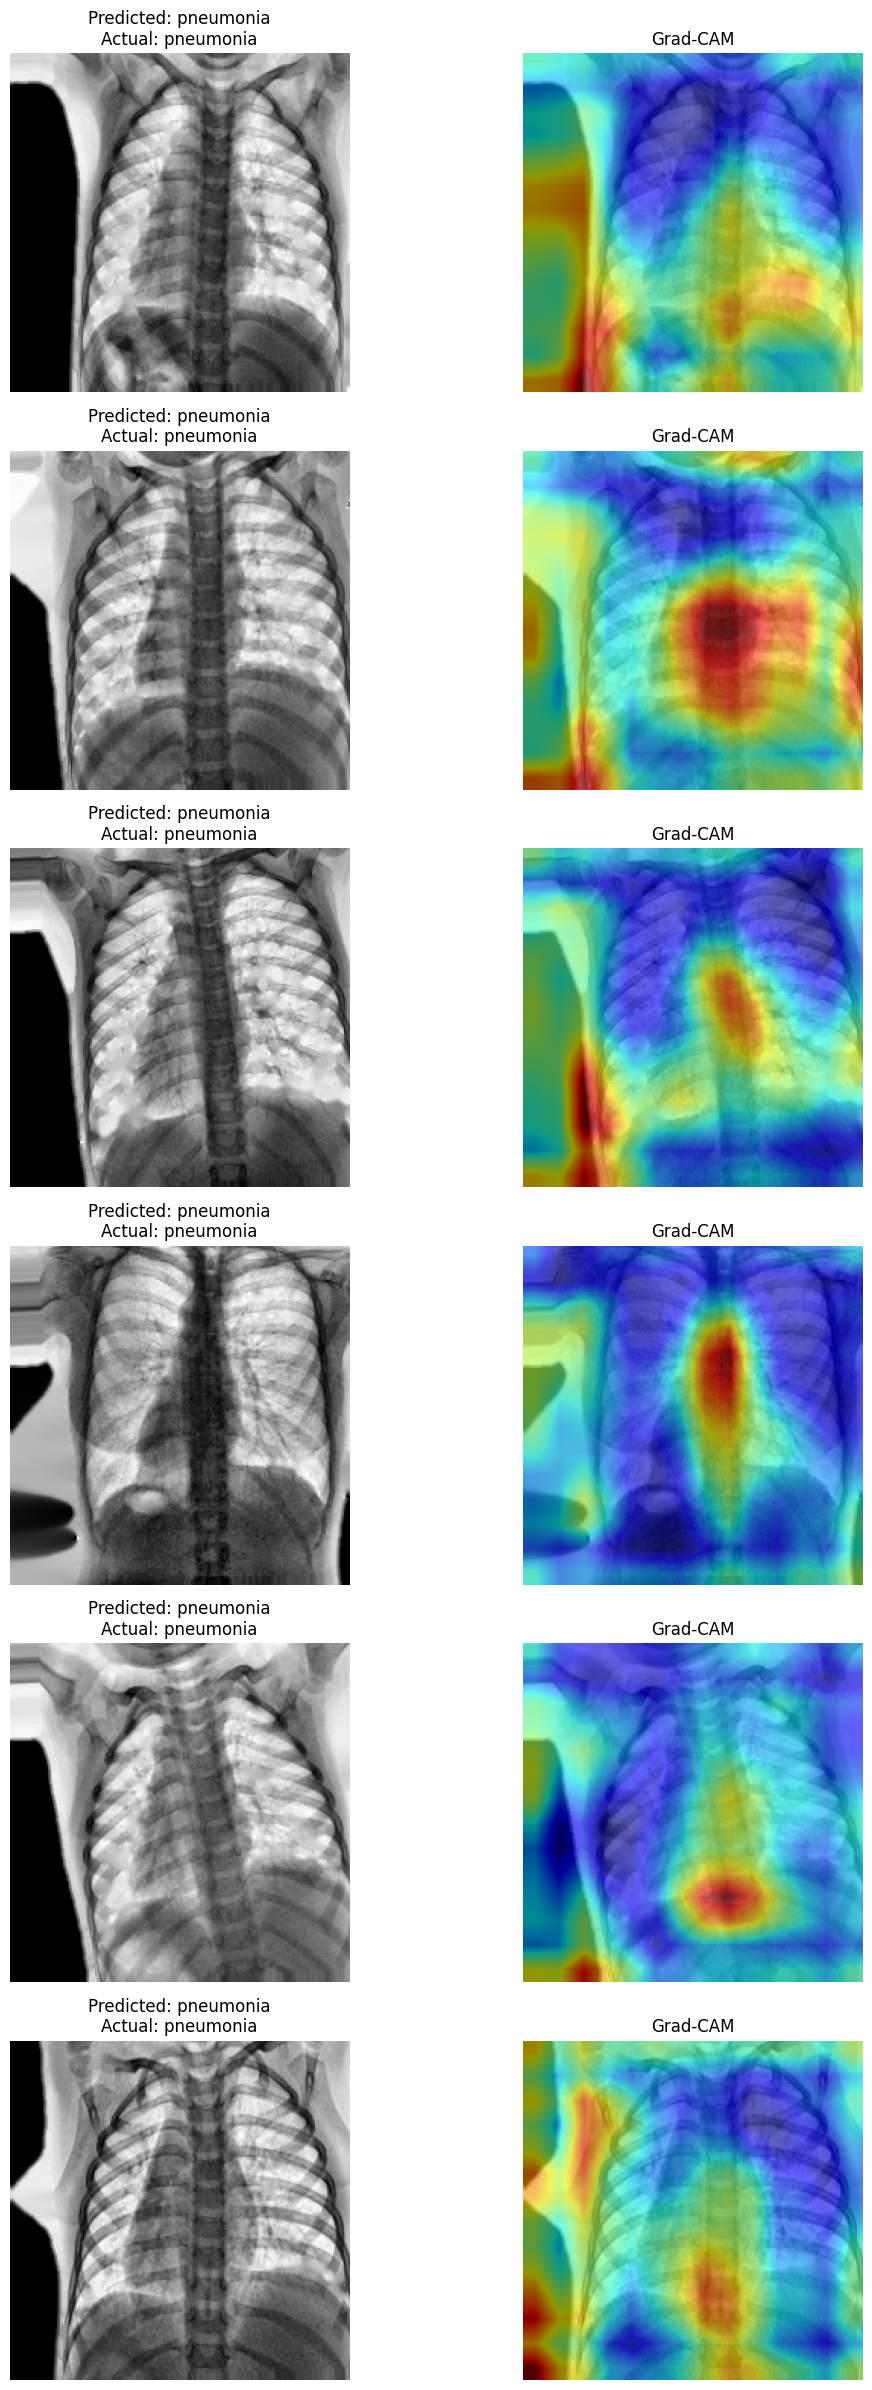

In [29]:
draw(test_images[:6], heatmaps[:6], test_labels_c[:6], pred)

# LIME with model for classifying Normal or Patient

In [30]:
heatmaps, pred = getHeatMap(test_images, test_labels, model, "Binary")
print(heatmaps.shape)

(128, 224, 224)


In [31]:
class_dict = {0:'Patient',
              1:'Normal',
         }

def draw(images, gradcam_heatmaps, labels, pred,  num_images=6):
    plt.figure(figsize=(12, 4 * num_images))
    for i in range(num_images):
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(images[i])
        title_pred = class_dict[pred[i][0]]
        title_actual = class_dict[np.argmax(labels[i])]
        plt.title(f'Predicted: {title_pred}\nActual: {title_actual}')

  
        
        plt.axis('off')

        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(images[i])
        plt.imshow(gradcam_heatmaps[i], alpha=0.6, cmap='jet')
        plt.title('Grad-CAM')
        plt.axis('off')

    plt.tight_layout()
    plt.show()



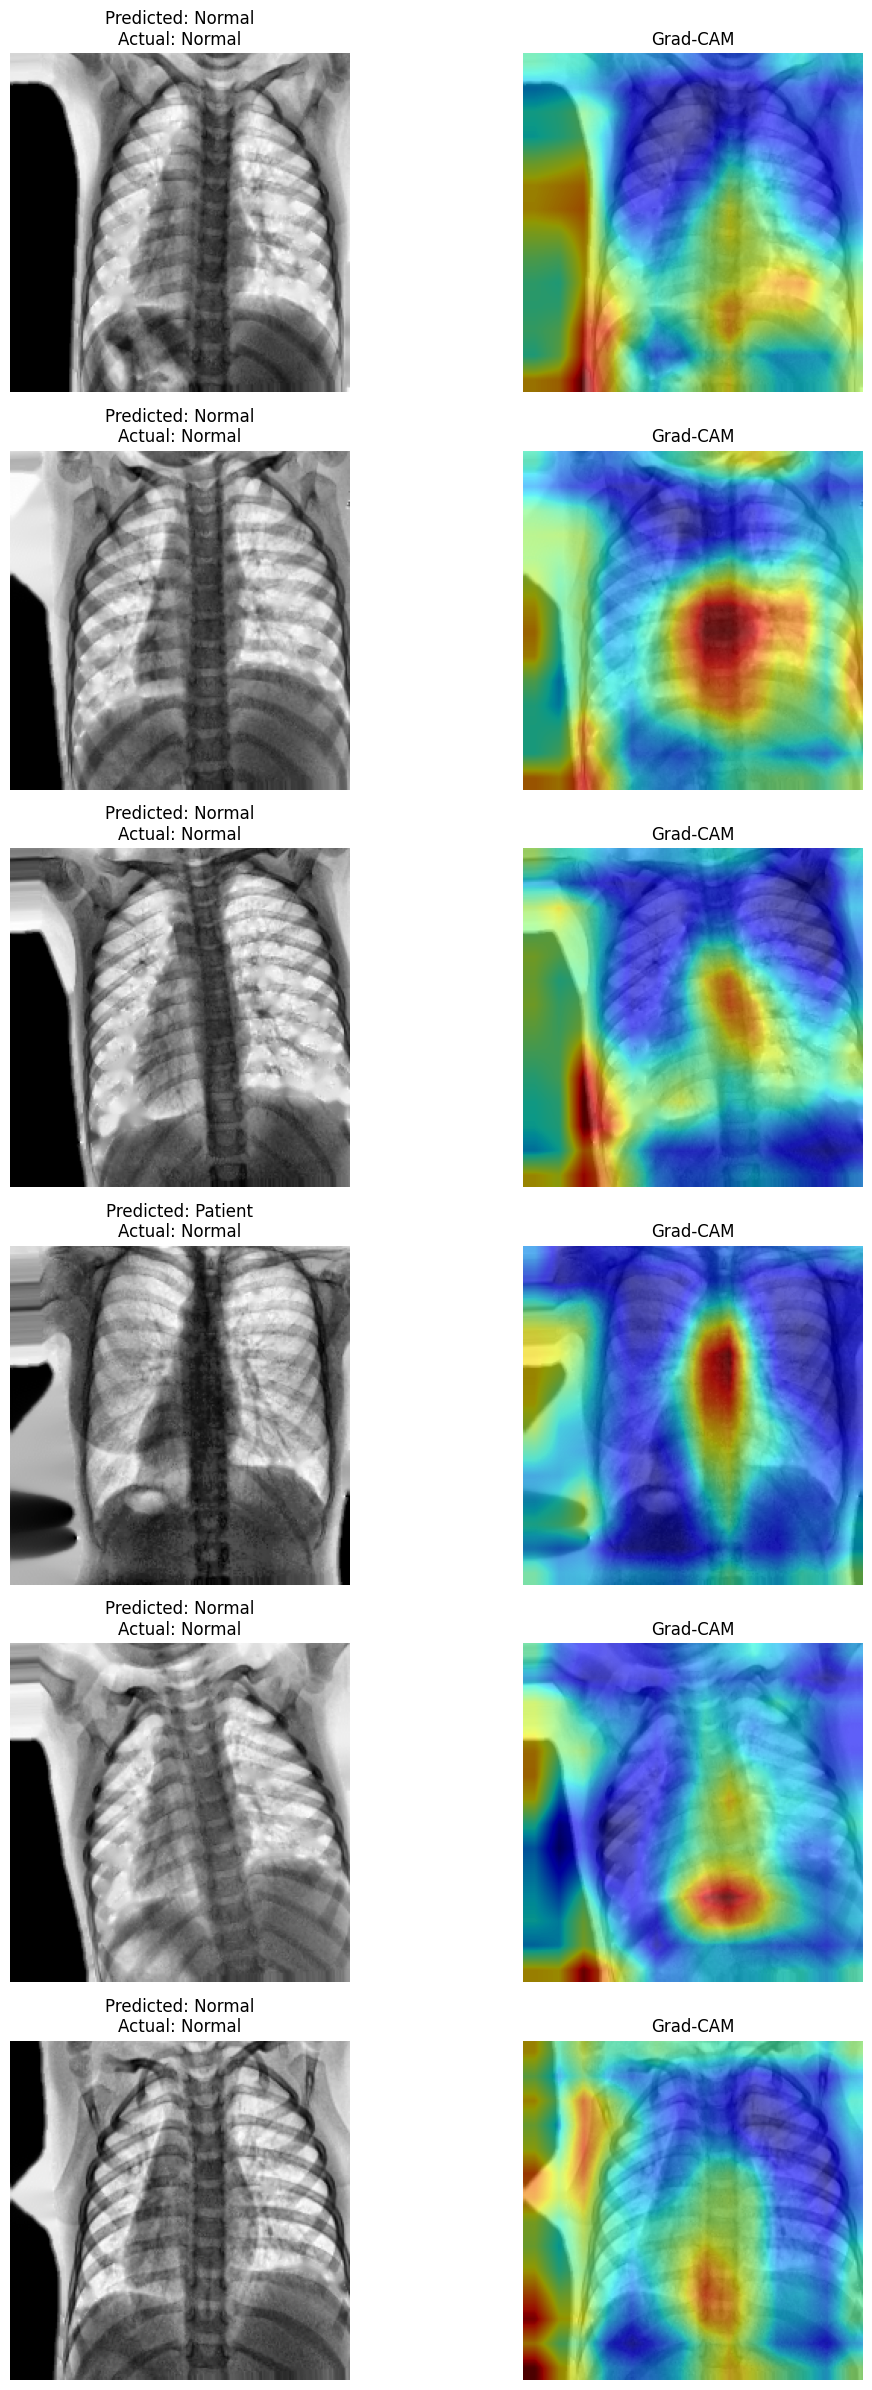

In [32]:
draw(test_images[:6], heatmaps[:6], test_labels[:6], pred)

# Explainability with Lime

# LIME with model for classifying Normal or Patient

In [33]:
class_labels = ["Normal", "Patient"]

In [34]:
def explain_with_lime_from_array(model, images, labels, class_labels, num_samples=3):
    explainer = lime_image.LimeImageExplainer()
    segmenter = SegmentationAlgorithm('quickshift', kernel_size=2, max_dist=100, ratio=0.2)

    for idx in range(num_samples):
        img = images[idx]
        label = labels[idx]

        img_normalized = img / 255.0 if img.max() > 1 else img

        try:
            explanation = explainer.explain_instance(
                img_normalized,
                predict_fn,
                top_labels=3,
                hide_color=None,
                num_samples=500,
                segmentation_fn=segmenter
            )
        except Exception as e:
            print(f"Error explaining image at index {idx}: {e}")
            continue

        pred = model.predict(np.expand_dims(img_normalized, axis=0), verbose=0)
        predicted_class = class_labels[np.argmax(pred)]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

        img_viz = img if img.shape[-1] == 3 else np.stack([img.squeeze()] * 3, axis=-1)
        ax1.imshow(img_viz.astype(np.float32))
        ax1.set_title(f'True: {class_labels[np.argmax(label)]}\nPredicted: {predicted_class}')

        ax1.axis('off')

        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=5,
            hide_rest=False
        )

        overlay = np.zeros_like(img_viz)
        overlay[mask == 1] = [1, 0, 0]
        alpha = 0.3
        highlighted_image = (1 - alpha) * img_viz + alpha * overlay
        highlighted_image = np.clip(highlighted_image, 0, 1)

        highlighted_image = mark_boundaries(highlighted_image, mask, color=(1, 0, 0), mode='thick')
        ax2.imshow(highlighted_image)
        ax2.set_title('LIME Highlights')
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Image Index: {idx}")
        print(f"Predicted probabilities: {dict(zip(class_labels, pred[0]))}\n")


In [35]:
class_labels = ['normal', 'patient']

explain_with_lime_from_array(model, test_images, test_labels, class_labels)


Error explaining image at index 0: name 'predict_fn' is not defined
Error explaining image at index 1: name 'predict_fn' is not defined
Error explaining image at index 2: name 'predict_fn' is not defined


# LIME with model for classifying Normal or Covid19 or Pneumonia

In [36]:
def preprocess_image(image_path):
    try:
        img = imread(image_path, as_gray=False)
        img = resize(img, (224, 224), anti_aliasing=True)
        if len(img.shape) == 2:
            img_rgb = np.stack([img] * 3, axis=-1)
        elif img.shape[-1] == 1:
            img_rgb = np.repeat(img, 3, axis=-1)
        else:
            img_rgb = img
        img_normalized = img_rgb / 255.0 if img_rgb.max() > 1 else img_rgb
        if len(img.shape) == 2 or (len(img.shape) == 3 and np.all(img[:, :, 0] == img[:, :, 1]) and np.all(img[:, :, 1] == img[:, :, 2])):
            img_viz = img if len(img.shape) == 2 else img[:, :, 0]
        else:
            img_viz = img_rgb
        return img_normalized, img_viz
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None, None

In [37]:
def explain_with_lime(model, image_paths_with_labels):
    explainer = lime_image.LimeImageExplainer()
    segmenter = SegmentationAlgorithm('quickshift', kernel_size=2, max_dist=100, ratio=0.2)

    for image_path, class_name in image_paths_with_labels:
        img_normalized, img_viz = preprocess_image(image_path)
        if img_normalized is None:
            print(f"Skipping {image_path} due to preprocessing error.")
            continue

        try:
            explanation = explainer.explain_instance(
                img_normalized,
                predict_fn,
                top_labels=3,
                hide_color=None,
                num_samples=500,
                segmentation_fn=segmenter
            )
        except Exception as e:
            print(f"Error explaining image {image_path}: {e}")
            continue

        pred = model.predict(np.expand_dims(img_normalized, axis=0), verbose=0)
        predicted_class = class_labels[np.argmax(pred)]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

        ax1.imshow(img_viz, cmap='gray' if len(img_viz.shape) == 2 else None)
        ax1.set_title(f'Original ({class_name})\nPredicted: {predicted_class}')
        ax1.axis('off')

        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=5,
            hide_rest=False
        )

        base_image = img_viz
        if len(base_image.shape) == 2:
            overlay = np.zeros_like(base_image)
            overlay[mask == 1] = 1
            alpha = 0.3
            highlighted_image = (1 - alpha) * base_image + alpha * overlay
            highlighted_image = np.clip(highlighted_image, 0, 1)
            cmap = 'gray'
        else:
            overlay = np.zeros_like(base_image)
            overlay[mask == 1] = [1, 0, 0]
            alpha = 0.3
            highlighted_image = (1 - alpha) * base_image + alpha * overlay
            highlighted_image = np.clip(highlighted_image, 0, 1)
            cmap = None

        highlighted_image = mark_boundaries(highlighted_image, mask, color=(1, 0, 0), mode='thick')
        ax2.imshow(highlighted_image, cmap=cmap)
        ax2.set_title('LIME Highlights')
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Image: {image_path}")
        print(f"Predicted probabilities: {dict(zip(class_labels, pred[0]))}\n")

In [38]:
class_labels = ['covid19', 'normal', 'pneumonia']
test_dir = '/kaggle/input/feature-selelcted-dataset/test'
try:
    image_paths = [
        (os.path.join(test_dir, 'covid19', os.listdir(os.path.join(test_dir, 'covid19'))[0]), 'covid19'),
        (os.path.join(test_dir, 'pneumonia', os.listdir(os.path.join(test_dir, 'pneumonia'))[0]), 'pneumonia'),
        (os.path.join(test_dir, 'normal', os.listdir(os.path.join(test_dir, 'normal'))[0]), 'normal')
    ]
    explain_with_lime(model_c, image_paths)
except Exception as e:
    print(f"Error loading sample images: {e}")

Error explaining image /kaggle/input/feature-selelcted-dataset/test/covid19/image_253.png: name 'predict_fn' is not defined
Error explaining image /kaggle/input/feature-selelcted-dataset/test/pneumonia/image_281.png: name 'predict_fn' is not defined
Error explaining image /kaggle/input/feature-selelcted-dataset/test/normal/image_301.png: name 'predict_fn' is not defined


# DeepLift

# LIME with model for classifying Normal or Patient

In [39]:
def deeplift(model, img, baseline=None, pred_index=None):
    if baseline is None:
        baseline = np.zeros_like(img)
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)
    
    # difference between input and baseline
    diff = img - baseline
    
    # gradients of the predicted class VS respect to the input
    with tf.GradientTape() as tape:
        tape.watch(img)
        preds = model(img)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        score = preds[:, pred_index]
    
    grads = tape.gradient(score, img)
    
    # DeepLIFT multipliers: approximate as gradients
    multipliers = grads
    
    # contribution scores: (input - baseline) * multipliers
    contributions = diff * multipliers
    
    # Sum across channels + absolute
    heatmap = tf.reduce_sum(tf.abs(contributions), axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-10)  # Normalize
    return heatmap, pred_index

In [40]:
def display_heatmap(img, heatmap, alpha=0.5):
    if img.ndim == 4:
        img = img[0]
    if heatmap.ndim == 3:
        heatmap = heatmap[0]
    
    img = np.uint8(255 * (img - img.min()) / (img.max() - img.min() + 1e-10))
    
    heatmap = np.uint8(255 * heatmap)
    heatmap = tf.image.resize(heatmap[..., np.newaxis], (img.shape[0], img.shape[1])).numpy()[..., 0]
    heatmap = np.uint8(plt.cm.jet(heatmap)[..., :3] * 255)
    
    superimposed_img = heatmap * alpha + img * (1 - alpha)
    return np.uint8(superimposed_img)

In [41]:
# Select 3 samples per class
num_classes = 2
samples_per_class = 2
class_indices = np.argmax(test_labels, axis=1)

selected_images = []
selected_labels = []

for class_idx in range(num_classes):
    # Find indices of samples belonging to this class
    class_samples = np.where(class_indices == class_idx)[0]
    if len(class_samples) < samples_per_class:
        print(f"Warning: Class {class_idx} has only {len(class_samples)} samples, using all available.")
        selected_samples = class_samples
    else:
        selected_samples = np.random.choice(class_samples, size=samples_per_class, replace=False)
    
    selected_images.extend(test_images[selected_samples])
    selected_labels.extend(test_labels[selected_samples])

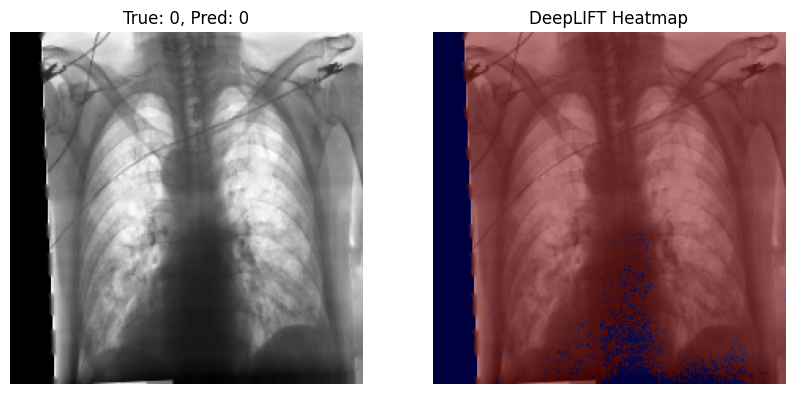

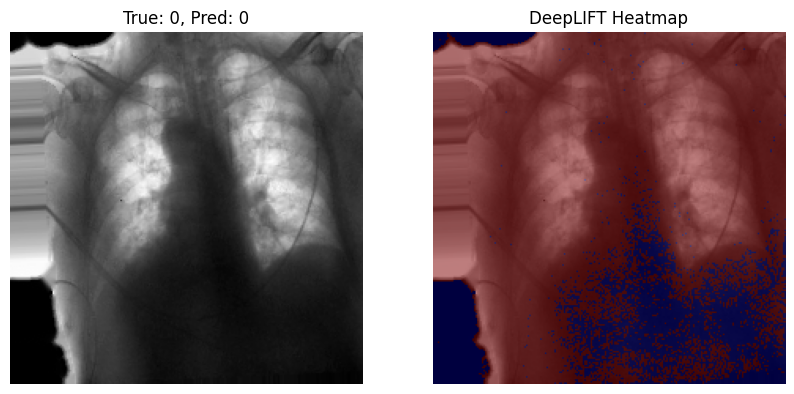

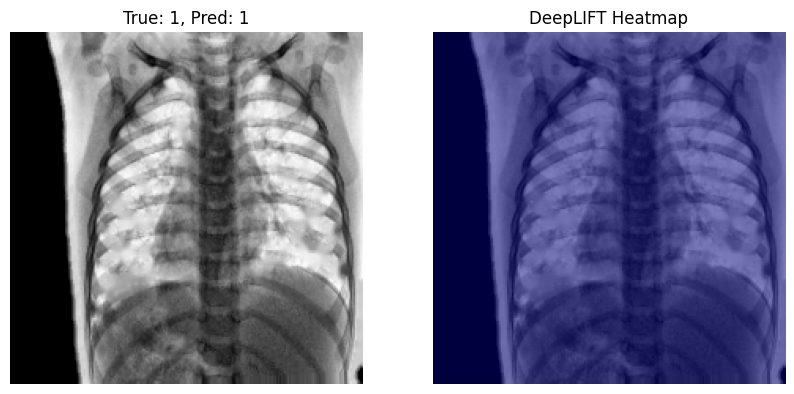

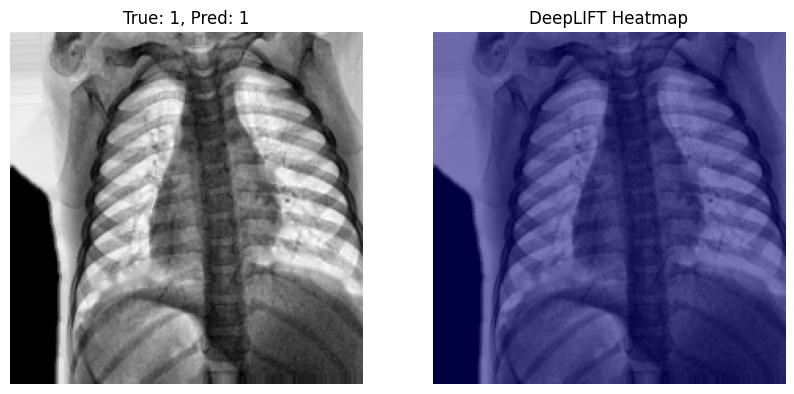

In [42]:
sample_images = np.array(selected_images)
sample_labels = np.array(selected_labels)

for i in range(len(sample_images)):
    img = sample_images[i:i+1]
    true_label = np.argmax(sample_labels[i])
    
    heatmap, pred_class = deeplift(model, img)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img[0])
    plt.title(f"True: {true_label}, Pred: {pred_class}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    superimposed_img = display_heatmap(img, heatmap)
    plt.imshow(superimposed_img)
    plt.title("DeepLIFT Heatmap")
    plt.axis('off')
    
    plt.show()

# LIME with model for classifying Normal or Covid19 or Pneumonia

In [43]:
# Select 3 samples per class
num_classes = 3
samples_per_class = 3
class_indices = np.argmax(test_labels_c, axis=1)

selected_images = []
selected_labels = []

for class_idx in range(num_classes):
    # Find indices of samples belonging to this class
    class_samples = np.where(class_indices == class_idx)[0]
    if len(class_samples) < samples_per_class:
        print(f"Warning: Class {class_idx} has only {len(class_samples)} samples, using all available.")
        selected_samples = class_samples
    else:
        selected_samples = np.random.choice(class_samples, size=samples_per_class, replace=False)
    
    selected_images.extend(test_images[selected_samples])
    selected_labels.extend(test_labels[selected_samples])

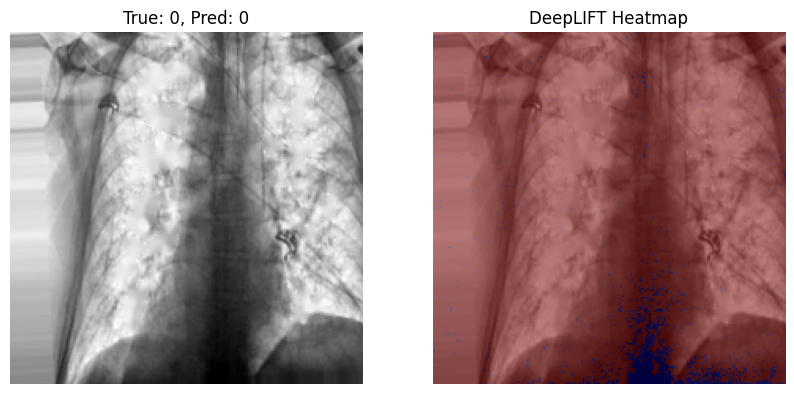

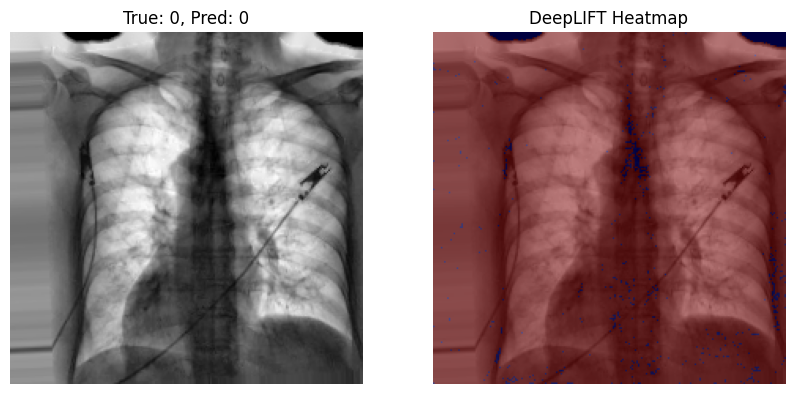

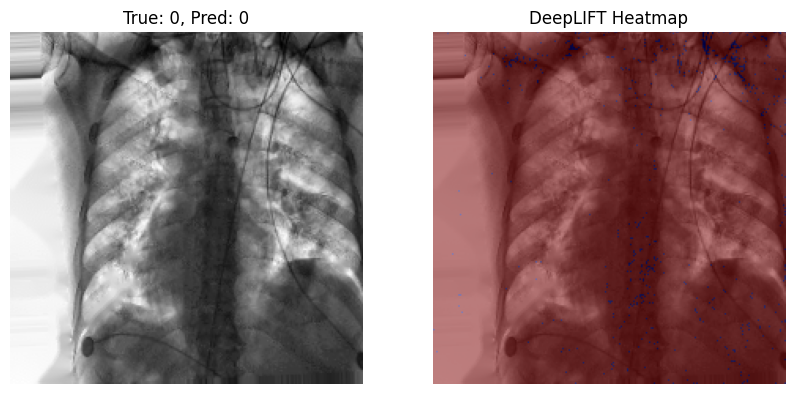

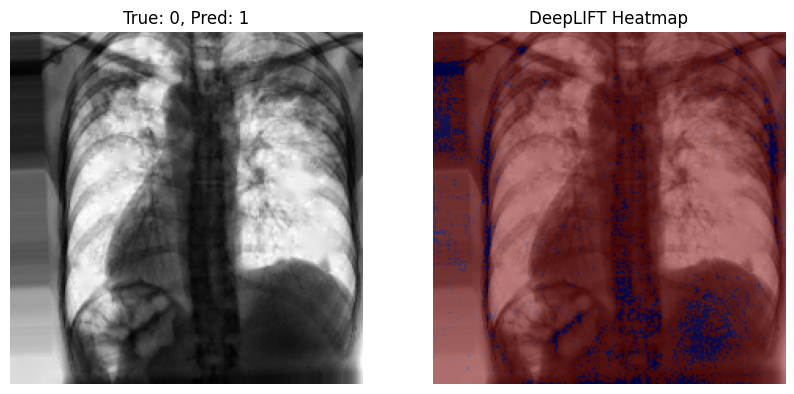

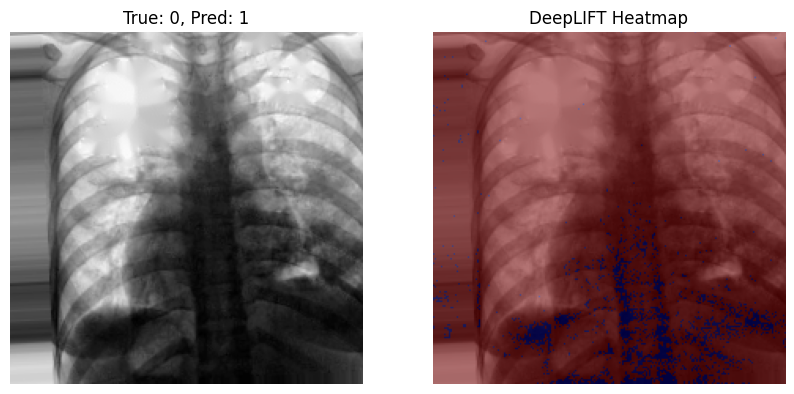

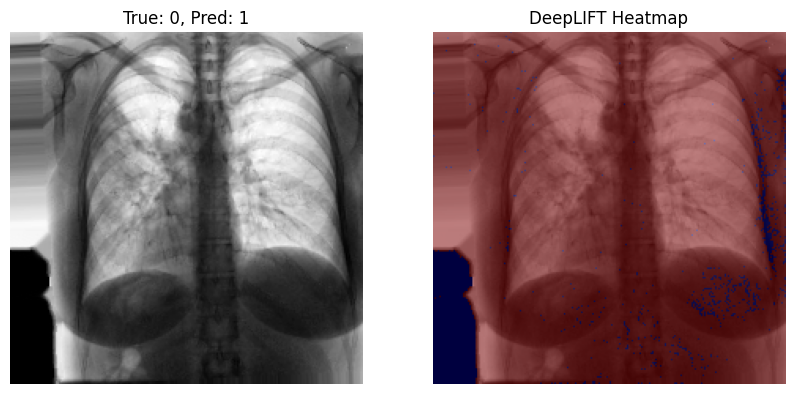

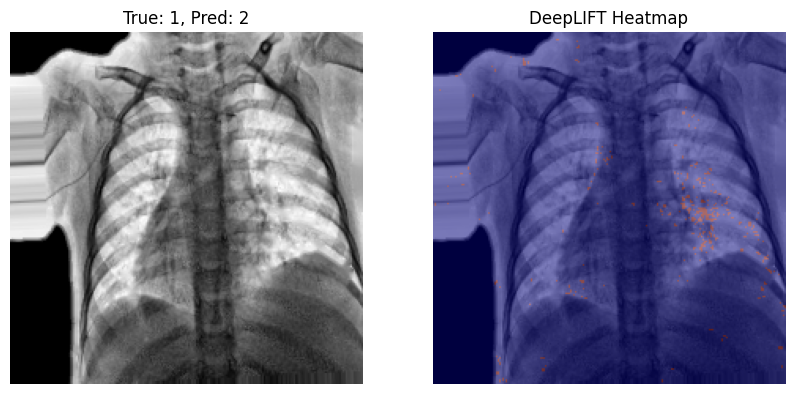

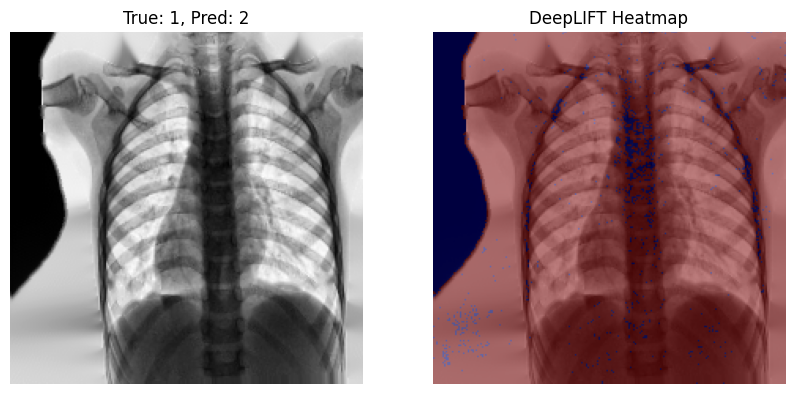

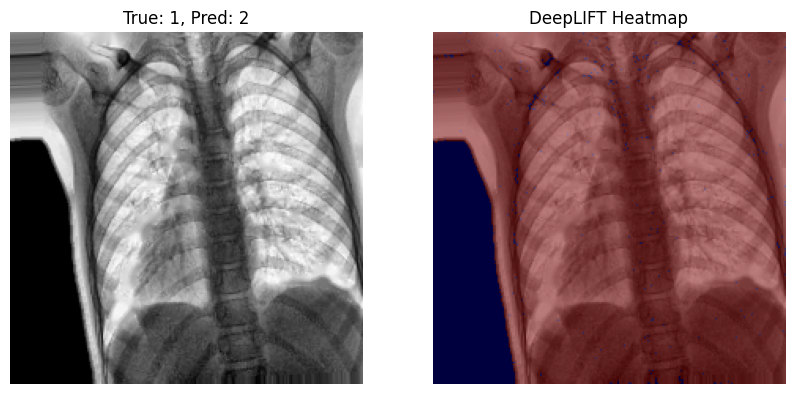

In [44]:
sample_images = np.array(selected_images)
sample_labels = np.array(selected_labels)

for i in range(len(sample_images)):
    img = sample_images[i:i+1]
    true_label = np.argmax(sample_labels[i])
    
    heatmap, pred_class = deeplift(model_c, img)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img[0])
    plt.title(f"True: {true_label}, Pred: {pred_class}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    superimposed_img = display_heatmap(img, heatmap)
    plt.imshow(superimposed_img)
    plt.title("DeepLIFT Heatmap")
    plt.axis('off')
    
    plt.show()